Inspired by the


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
Blue, Orange, Green, Red, Purple, Brown, Pink, Grey,\
    Kaki, Cyan = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'

# Single neuron model: leaky Integrate and Fire

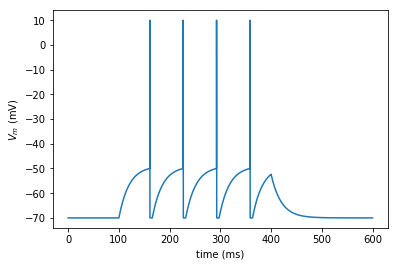

In [2]:
dt, tstop = 1e-4, 0.6
t = np.arange(int(tstop/dt))*dt

def I_func(t, V):
    if (t>0.1) and (t<0.4):
        return 210e-12
    else:
        return 0

def membrane_dynamics(t, I_func,
                      Cm=200e-12, Gl=10e-9, El=-70e-3,
                      Vthre=-50e-3, Vspk=10e-3, Trefrac=5e-3):
    """
    Function solving the single neuron membrane potential dynamics given a 
    time-and-voltage-dependent Current function "I_func"
    """
    v, t_lastspike = [El], -np.inf
    for i in range(1, len(t)):
        if (v[i-1]>=Vthre) and not (v[i-1]==Vspk):
            v.append(Vspk)
            t_lastspike = t[i]
        elif (t[i]-t_lastspike)<Trefrac:
            v.append(El)
        else:
            v.append(v[i-1]+dt/Cm*(I_func(t[i], v[i-1])+Gl*(El-v[i-1])))
    
    return np.array(v)

plt.plot(1e3*t, 1e3*membrane_dynamics(t, I_func))
plt.xlabel('time (ms)');plt.ylabel('$V_m$ (mV)')

# Shaping synaptic currents

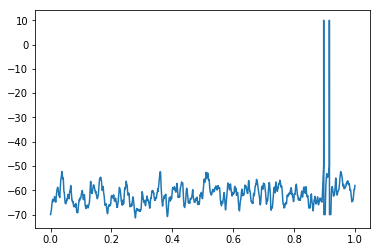

In [3]:
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt

def I_func(t, V, Ga, Ge, Gi, Freq_func,\
           dt=dt,
           Qa=4e-9, Na=10, Ea=0e-3, Ta=5e-3,
           Qe=2e-9, Ne=200, Ee=0e-3, Te=5e-3,
           Qi=10e-9, Ni=50, Ei=-80e-3, Ti=5e-3):

    Ga -= Ga*dt/Ta
    Ge -= Ge*dt/Te
    Gi -= Gi*dt/Ti
    
    # drawing random numbers to decide whether synaptic currents
    pa, pe, pi = np.random.uniform(0, 1., size=3)
    fa, fe, fi = Freq_func(t)
    if pa<dt*fa*Na:
        Ga += Qa
    if pe<dt*fe*Ne:
        Ge += Qe
    if pi<dt*fi*Ni:
        Gi += Qi

    # now we return synaptic currents
    return Ga*(Ea-V)+Ge*(Ee-V)+Gi*(Ei-V), Ga, Ge, Gi

def membrane_dynamics(t, I_func, Freq_func,
                      dt=1e-4,
                      Cm=200e-12, Gl=10e-9, El=-70e-3,
                      Vthre=-50e-3, Vspk=10e-3, Trefrac=5e-3):
    """
    Function solving the single neuron membrane potential dynamics given a 
    time-and-voltage-dependent Current function "I_func"
    """
    Ga, Ge, Gi = [0], [0], [0]
    v, t_lastspike = [El], -np.inf
    for i in range(1, len(t)):
        if (v[i-1]>=Vthre) and not (v[i-1]==Vspk):
            v.append(Vspk)
            t_lastspike = t[i]
        elif (t[i]-t_lastspike)<Trefrac:
            v.append(El)
        else:
            Isyn, ga, ge, gi = I_func(t[i], v[i-1], Ga[i-1], Ge[i-1], Gi[i-1], Freq_func)
            v.append(v[i-1]+dt/Cm*(Isyn+Gl*(El-v[i-1])))
        Ga.append(ga)
        Ge.append(ge)
        Gi.append(gi)
    return np.array(v)

def F(t):
    """ returns the afferent, excitatory and inhibitory frequencies respectively"""
    return 10., 7., 20.

plt.plot(t, 1e3*membrane_dynamics(t, I_func, F, dt=dt))

# Setting up the background activity

## Constructing the comodulation of afferent excitation and inhibition

### (based on a theoretical study in recurrent networks, Zerlaut et al. ~2017)

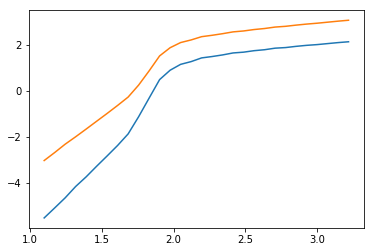

In [4]:
FA, _, _, _, EXC_ACT, INH_ACT, _, _, _ = np.load('comodulation_in_recurrent_ntwks.npy')
Fa, Fe, Fi = np.unique(np.unique(FA)), [], []
for fa in Fa:
    i0 = np.argwhere(np.array(FA)==fa)
    Fe.append(EXC_ACT[i0].mean())
    Fi.append(INH_ACT[i0].mean())
lFa, lFe, lFi = np.log(Fa), np.log(Fe), np.log(Fi)
plt.plot(lFa, lFe)
plt.plot(lFa, lFi)

In [5]:
polE = np.polyfit(lFa, lFe, 12)
polI = np.polyfit(lFa, lFi, 12)

def print_pol_function(pol, func_name='Fe_func'):
    S = 'def '+func_name+'(Fa):\n    x=np.log(Fa+1e-5)\n'
    S += '    y = '
    for i, p in enumerate(pol):
        S += ' +'+str(p)+'*x**'+str(len(pol)-1-i)
    S += '\n'
    S += '    return np.exp(y) \n'
    return S
S = print_pol_function(polE, func_name='Fe_func')
S += print_pol_function(polI, func_name='Fi_func')
print(S)
f = open('temp.txt', 'w')
f.write(S)
f.close()

def Fe_func(Fa):
    x=np.log(Fa+1e-5)
    y =  +-56.550681238*x**12 +1496.63903733*x**11 +-17952.4658914*x**10 +128992.047099*x**9 +-617999.512402*x**8 +2078750.16648*x**7 +-5031200.42987*x**6 +8824045.46324*x**5 +-11125673.8299*x**4 +9831154.25688*x**3 +-5777670.27308*x**2 +2027265.10702*x**1 +-321162.542745*x**0
    return np.exp(y) 
def Fi_func(Fa):
    x=np.log(Fa+1e-5)
    y =  +-35.0352278809*x**12 +933.942765539*x**11 +-11283.6946933*x**10 +81656.9023314*x**9 +-393994.162019*x**8 +1334548.73485*x**7 +-3252242.27083*x**6 +5742448.17542*x**5 +-7287927.18875*x**4 +6481175.90263*x**3 +-3832586.64742*x**2 +1352868.85255*x**1 +-215571.343599*x**0
    return np.exp(y) 



In [6]:
def Fe_func(Fa):
    x=np.log(Fa+1e-5)
    y =  +-56.550681238*x**12 +1496.63903733*x**11 +-17952.4658914*x**10 +128992.047099*x**9 +-617999.512402*x**8 +2078750.16648*x**7 +-5031200.42987*x**6 +8824045.46324*x**5 +-11125673.8299*x**4 +9831154.25688*x**3 +-5777670.27308*x**2 +2027265.10702*x**1 +-321162.542745*x**0
    return np.exp(y) 

def Fi_func(Fa):
    x=np.log(Fa+1e-5)
    y =  +-35.0352278809*x**12 +933.942765539*x**11 +-11283.6946933*x**10 +81656.9023314*x**9 +-393994.162019*x**8 +1334548.73485*x**7 +-3252242.27083*x**6 +5742448.17542*x**5 +-7287927.18875*x**4 +6481175.90263*x**3 +-3832586.64742*x**2 +1352868.85255*x**1 +-215571.343599*x**0
    return np.exp(y) 

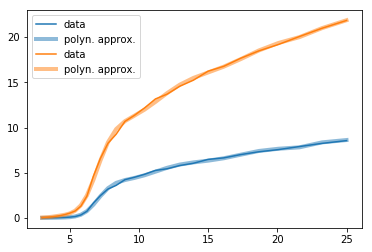

In [7]:
plt.plot(Fa, Fe, color=Blue, label='data')
plt.plot(Fa, Fe_func(Fa), lw=4, alpha=.5, color=Blue, label='polyn. approx.')
plt.plot(Fa, Fi, color=Orange, label='data')
plt.plot(Fa, Fi_func(Fa), lw=4, alpha=.5, color=Orange, label='polyn. approx.')
plt.legend()

## Setting up (slow) modulations of the network activity corresponding to various conditions

### Deeply anesthetized

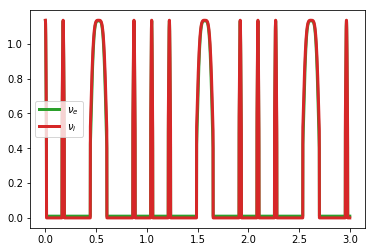

In [8]:
def deeply_anesthetized(t, f=3., Fa0=13., Fe0=1e-2):
    y0 = np.cos(2.*np.pi*np.sin(f*t))**6
    y = (np.sign(y0-0.9)+1)*y0/4.
    return Fa0*y, Fe_func(Fa0*y)+Fe0, Fi_func(Fa0*y)/3.

dt, tstop = 1e-4, 3.
t = np.arange(int(tstop/dt))*dt
_, Fe, Fi = np.array([deeply_anesthetized(tt) for tt in t]).T

plt.plot(t, Fe, label='$\\nu_e$', color=Green, lw=3)
plt.plot(t, Fi, label='$\\nu_i$', color=Red, lw=3)
plt.legend()

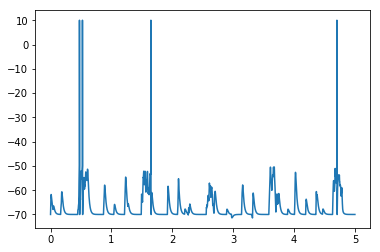

In [9]:
dt, tstop = 1e-4, 5.
t = np.arange(int(tstop/dt))*dt
plt.plot(t, 1e3*membrane_dynamics(t, I_func, deeply_anesthetized, dt=dt))

## Sleep / Anesthetized

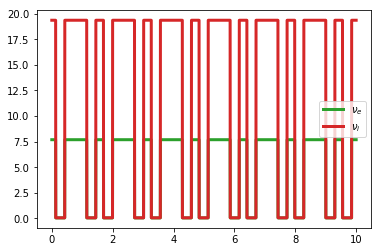

In [10]:
def sleep(t, f=2., Fa0=20., Fi0=5e-2, Fe0=4e-2):
    y = (1+np.sign(np.cos(2.*np.pi*np.sin(f*t))))/2.
    return Fa0*y, Fe_func(Fa0*y)+Fe0, Fi_func(Fa0*y)+Fi0

dt, tstop = 1e-4, 10.
t = np.arange(int(tstop/dt))*dt
_, Fe, Fi = np.array([sleep(tt) for tt in t]).T

plt.plot(t, Fe, label='$\\nu_e$', color=Green, lw=3)
plt.plot(t, Fi, label='$\\nu_i$', color=Red, lw=3)
plt.legend()

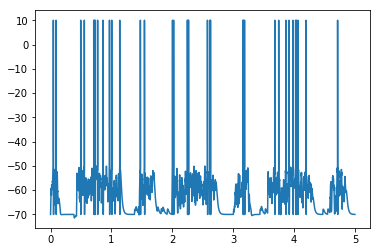

In [11]:
dt, tstop = 1e-4, 5.
t = np.arange(int(tstop/dt))*dt
plt.plot(t, 1e3*membrane_dynamics(t, I_func, sleep, dt=dt))

## Awake

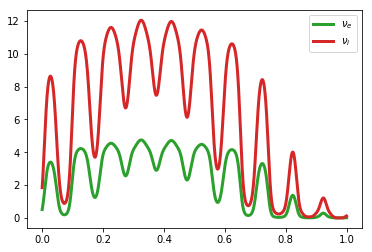

In [12]:
def awake(t, f1=0.7, f2=10., Fa0=3., Fi0=5e-2, Fe0=4e-2):
    y = Fa0*(1+(np.sin(2.*np.pi*np.sin(f1*t))+1)+1/2.*np.sin(2.*np.pi*f2*t))
    return y, Fe_func(y), Fi_func(y)

dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt
_, Fe, Fi = np.array([awake(tt) for tt in t]).T

plt.plot(t, Fe, label='$\\nu_e$', color=Green, lw=3)
plt.plot(t, Fi, label='$\\nu_i$', color=Red, lw=3)
plt.legend()                                     

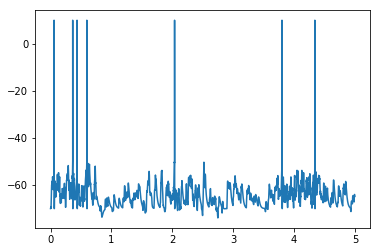

In [13]:
dt, tstop = 1e-4, 5.
t = np.arange(int(tstop/dt))*dt
plt.plot(t, 1e3*membrane_dynamics(t, I_func, awake, dt=dt))